In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [2]:
class SequentialCourseDataset(Dataset):
    def __init__(self, X, mask, y=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            'y': self.y[idx] if self.y is not None else None
        }
# Note: TCN không cần mask vì dùng causal padding

In [3]:
# ĐƯỜNG DẪN CỦA BẠN
TRAIN_PATH = r"/home/check/DATA/university/yr3, hk1/DS317 - Khai phá dữ liệu trong doanh nghiệp/3 Do an cuoi ky/data/course_train.npz"
TEST_PATH  = r"/home/check/DATA/university/yr3, hk1/DS317 - Khai phá dữ liệu trong doanh nghiệp/3 Do an cuoi ky/data/course_test.npz"

data_train = np.load(TRAIN_PATH, allow_pickle=True)
X_full = data_train['X']
y_full = (data_train['y'] - 1).astype(np.int64)

data_test = np.load(TEST_PATH, allow_pickle=True)
X_test = data_test['X']
y_test = (data_test['y'] - 1).astype(np.int64)

# Chia val 10%
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.1, random_state=42, stratify=y_full
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 38)).reshape(X_train.shape)
X_val   = scaler.transform(X_val.reshape(-1, 38)).reshape(X_val.shape)
X_test  = scaler.transform(X_test.reshape(-1, 38)).reshape(X_test.shape)

print("Data ready for TCN!")

Data ready for TCN!


In [ ]:
batch_size = 512  # TCN rất nhẹ, batch lớn ok

train_loader = DataLoader(SequentialCourseDataset(X_train, None, y_train), batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(SequentialCourseDataset(X_val,   None, y_val),   batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
test_loader  = DataLoader(SequentialCourseDataset(X_test,  None, y_test),  batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)  # Chomp2 → Chomp1d (fix typo nếu có)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs=38, num_channels=[64]*6, kernel_size=3, dropout=0.3, num_classes=5):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size  # causal padding
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=padding, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, features, seq_len)
        out = self.network(x)
        out = out[:, :, -1]  # last timestep
        return self.fc(out)

In [14]:
os.makedirs('models', exist_ok=True)

train_losses = []
val_macro_f1s = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TCN(
    num_inputs=38,
    num_channels=[64, 64, 128, 128, 256, 256],  # tăng dần channel
    kernel_size=3,
    dropout=0.3,
    num_classes=5
).to(device)

criterion = nn.CrossEntropyLoss()  # TCN thường không cần class_weights mạnh
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scaler_amp = GradScaler()

best_f1 = 0
for epoch in range(6):  # TCN hội tụ nhanh
    model.train()
    train_loss_epoch = 0
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(batch['X'].to(device))
            loss = criterion(logits, batch['y'].to(device))
        scaler_amp.scale(loss).backward()
        scaler_amp.step(optimizer)
        scaler_amp.update()
        train_loss_epoch += loss.item()
    train_losses.append(train_loss_epoch / len(train_loader))
    
    # Val
    model.eval()
    val_preds, val_trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            logits = model(batch['X'].to(device))
            val_preds.extend(torch.argmax(logits,1).cpu().numpy())
            val_trues.extend(batch['y'].numpy())
    val_f1 = f1_score(val_trues, val_preds, average='macro')
    print(f"Epoch {epoch+1} | Val Macro F1: {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'models/best_tcn.pth')
        joblib.dump(scaler, 'models/tcn_scaler.pkl')
        print("  → Saved best!")

# Test evaluation (copy từ GRU)

/tmp/ipykernel_147344/2663843311.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = GradScaler()
/tmp/ipykernel_147344/2663843311.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Val Macro F1: 0.6266
  → Saved best!


/tmp/ipykernel_147344/2663843311.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 | Val Macro F1: 0.7584
  → Saved best!


/tmp/ipykernel_147344/2663843311.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 | Val Macro F1: 0.8563
  → Saved best!


/tmp/ipykernel_147344/2663843311.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 | Val Macro F1: 0.8888
  → Saved best!


/tmp/ipykernel_147344/2663843311.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 | Val Macro F1: 0.9171
  → Saved best!


/tmp/ipykernel_147344/2663843311.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 | Val Macro F1: 0.9419
  → Saved best!


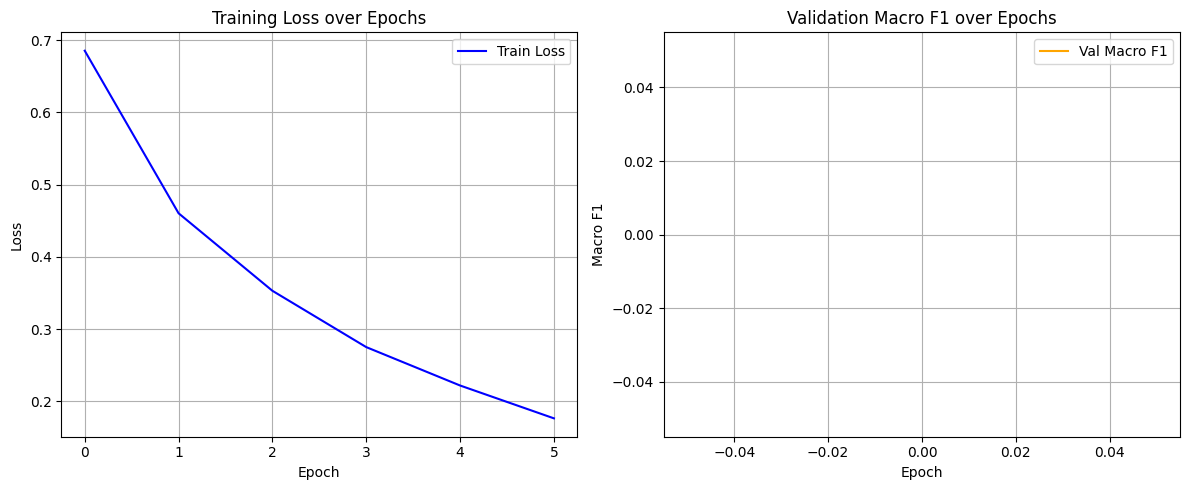

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_macro_f1s, label='Val Macro F1', color='orange')
plt.title('Validation Macro F1 over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

=== KẾT QUẢ TRÊN TEST SET - TCN ===
Accuracy: 0.6467
Macro F1: 0.5434
Weighted F1: 0.6538

Classification Report:
              precision    recall  f1-score   support

           1     0.7952    0.7235    0.7576      9266
           2     0.7750    0.8044    0.7894      7310
           3     0.1627    0.2406    0.1942      1492
           4     0.4538    0.4961    0.4740      4773
           5     0.5741    0.4460    0.5020      2693

    accuracy                         0.6467     25534
   macro avg     0.5522    0.5421    0.5434     25534
weighted avg     0.6653    0.6467    0.6538     25534



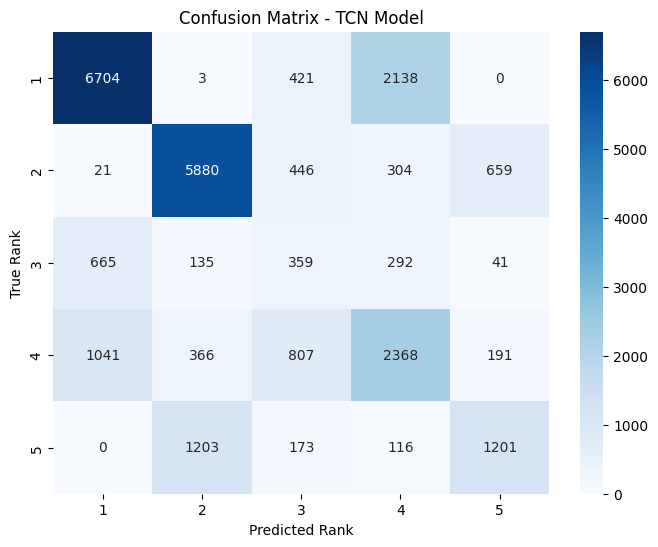

In [16]:
# Load best model
model.load_state_dict(torch.load('models/best_tcn.pth'))
model.eval()

# Inference trên test set
test_preds = []
test_trues = y_test  # y_test đã có từ load data

with torch.no_grad():
    for batch in test_loader:
        logits = model(batch['X'].to(device))
        test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

test_preds = np.array(test_preds)

# Tính metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(test_trues, test_preds)
macro_f1 = f1_score(test_trues, test_preds, average='macro')
weighted_f1 = f1_score(test_trues, test_preds, average='weighted')

print("=== KẾT QUẢ TRÊN TEST SET - TCN ===")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_trues + 1, test_preds + 1, digits=4))  # +1 để hiển thị rank 1-5

# Confusion Matrix
cm = confusion_matrix(test_trues + 1, test_preds + 1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix - TCN Model')
plt.xlabel('Predicted Rank')
plt.ylabel('True Rank')
plt.show()